# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import mode
from inspect import stack
import sys
import seaborn as sns

# Некоторые промежуточные функции

## Функция промежуточных сумм

In [8]:
def subtotals(x):
    X = sorted(list(set(x)))
#     print(X)
    res = np.zeros(len(X)-1)
    for i in range(len(X) - 1):
        res[i] = (X[i] + X[i+1])/2
    return res

st = [1,2,10,10,10,10,10,3,4,5,6,7,7,7,7,7]
res = subtotals(st)
print(f'Вход: {st}')
print(f'Выход: {res}')

Вход: [1, 2, 10, 10, 10, 10, 10, 3, 4, 5, 6, 7, 7, 7, 7, 7]
Выход: [1.5 2.5 3.5 4.5 5.5 6.5 8.5]


## Функция подсчета уровня рекурсии

In [9]:
def f():
    return len(stack())-25

## Задание 1 (1 балл)

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [166]:
def gini(x_in):
    x = np.array(x_in)
#     print(type(x_in))
    labels = list(set(np.array(x_in).flatten()))
    m = len(labels)
    n = len(x)
    Y = dict()
#     for i in range(m):
#         print(x.shape, type(x), x)
#         Y[x[i]] = 0
    Y = {0:0, 1:0}
    for i in range(n):
#         print(Y, type(x), x)
        key = x[i]
#         print(x[i])
        Y[x[i][0]] += 1/n
    
    S = 0
    for key in Y.keys():
        S += Y[key]*(1 - Y[key])
        
    
    return S
    
def entropy(x_in):
    x = np.array(x_in)
    labels = list(set(list(x_in)))
    m = len(labels)
    n = len(x)
    Y = {label:0 for label in labels}
    
    for i in range(n):
        Y[x[i]] += 1/n
        
    S = 0
    
    for key in Y.keys():
        S -= Y[key]*np.log2(Y[key])
    return S

def gain(left_y, right_y, criterion):
    y = list(left_y) + list(right_y)
    n_left = len(left_y)
    n_right = len(right_y)
    n_all = n_left + n_right
    return (n_all*criterion(y) - n_right*criterion(right_y) - n_left*criterion(left_y))/n_all

test1 = [2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
test2 = [2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,2,2,2,2,2,1,1,1,1,1,1,1,2]
test = mode(test1)
test[0][0]

1

## Задание 2 (1 балл)

Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [169]:
class DecisionTreeLeaf:
    def __init__(self, y):
#         self.mode = mode(y)[0][0]
        self.N = len(y)
        self.set = list(set(y.flatten()))
        self.y = list(y)
#         raise NotImplementedError()

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
#         raise NotImplementedError()

## Задание 3 (6 баллов)

Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [170]:
class DecisionTreeClassifier:

    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        else:
            raise NotImplementedError()
    def build(self, X, y):
        cur_rec = f()
        
        min_IG = -np.inf
        test = False
        res_column = 1
        res_threshold = np.inf
        for column in range(X.shape[1]):
            X_temp = X[:, column]
            if len(set(X_temp)) > 300:
                thresholds = subtotals(np.array(X_temp))[::len(X_temp)//10]
            else:
                thresholds = sorted(list(set(X_temp)))
            for threshold in thresholds:
                left = y[X_temp < threshold]
                right = y[X_temp >= threshold]
                if len(left) <= self.min_samples_leaf or len(right) <= self.min_samples_leaf:
                    continue
                IG = gain(left, right, self.criterion)
                if IG > min_IG: 
                    test = True
                    res_column = column
                    min_IG = IG
                    res_threshold = threshold
        
        yl = y[X[:, res_column] < res_threshold]
        yr = y[X[:, res_column] >= res_threshold]
        Xl = np.delete(X[X[:, res_column] < res_threshold], res_column, axis=1)
        Xr = np.delete(X[X[:, res_column] >= res_threshold], res_column, axis=1)
        if self.max_depth is None:
            key = False
        elif cur_rec < self.max_depth:
            key = False
        else:
            key = True
            

        if (key) or X.shape[1]<=1  or res_threshold == np.inf:
            return DecisionTreeLeaf(y)
        else:
            return DecisionTreeNode(res_column, res_threshold,
                                    self.build(Xl, yl),
                                    self.build(Xr, yr))

    def fit(self, X, y):
        self.root = self.build(X, y)

    def search(self, x, Node):
        if type(Node) is DecisionTreeLeaf:
            res = dict()
            for key in Node.set:
                res[key] = Node.y.count(key)/Node.N
            return res
        elif type(Node) is DecisionTreeNode:
            if x[Node.split_dim] < Node.split_value:
                return self.search(x, Node.left)
            elif x[Node.split_dim] >= Node.split_value:
                return self.search(x, Node.right)
        else:
            raise NotImplementedError()
        
    def predict_proba(self, X):
#         X = X_in.drop('Id', axis=1)
#         IDs = X_in.Id
        pred = []
        N = len(X)
        for i in range(N):
            x = X[i]
            pred += [self.search(x, self.root)]
        
        return pred

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.array([max(p.keys(), key=lambda k: p[k]) for p in proba])

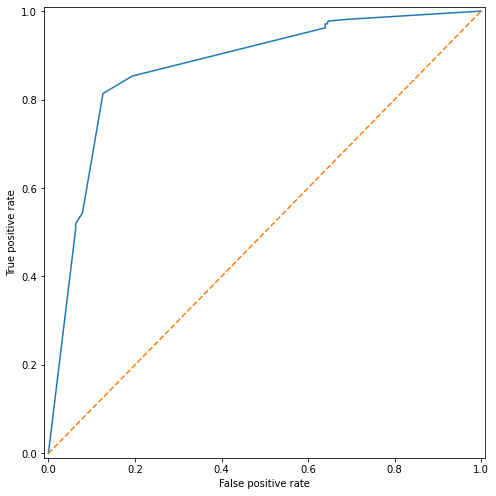

In [172]:
all_X = np.delete(np.array(pd.read_csv('x_spam_train.csv')), 0, axis=1)
all_y = np.delete(np.array(pd.read_csv('y_spam_train.csv')), 0, axis=1)
coef = 0.7
N = round(len(all_X)*coef)
X_train = all_X[:N]
y_train = all_y[:N]
X_test = all_X[N:]
y_test = all_y[N:]
tree = DecisionTreeClassifier(max_depth=None, min_samples_leaf=30)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
plot_roc_curve(y_test, tree.predict_proba(X_test))
# draw_tree(tree, save_path='test.png')

In [105]:
test = np.array([[1,2],[3,4],[5,6]])
test2 = np.array([[ True,  True],
       [False, False],
       [False, False]])
test[test2 == False]

array([3, 4, 5, 6])

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [13]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [14]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
#     plt.tight_layout()
    plt.show()


## Задание 4 (2 балла)

Протестируйте решение на датасете spam.
Для этой задачи используйте данные x_spam_train и y_spam_train:
1. Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2. Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3. Посчитайте метрики `precision`, `recall`, `accuracy` для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4. Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`).
5. Ответьте на следующие вопросы:
    - Какой нужен препроцессинг данных для моделей?
    - Какая модель делает предсказания лучше?  Предположите, почему.

In [18]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.neighbors import KNeighborsClassifier

In [47]:
all_X = pd.read_csv('x_spam_train.csv')
all_y = np.array(pd.read_csv('y_spam_train.csv'))
X_train = np.array(all_X.iloc[:round(len(all_X)*0.7)].drop('Id', axis=1))
y_train = all_y[:round(len(all_X)*0.7), 1]
X_test = all_X.iloc[round(len(all_X)*0.7):, 1]
y_test = all_y[round(len(all_X)*0.7):, 1]
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
plot_roc_curve(y_test, tree.predict_proba(X_test))
# draw_tree(tree, save_path='test.png')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2576 but corresponding boolean dimension is 57

### Метрики для дерева

In [173]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy = {acc:.3f}')
print(f'Recall = {recall:.3f}')
print(f'Precision = {precision:.3f}')
print(f'F1-score = {f1:.3f}')

Accuracy = 0.724
Recall = 0.356
Precision = 0.893
F1-score = 0.509


### Метрики для KNN

In [ ]:
est = KNeighborsClassifier()
est.fit(X_train, y_train)
y_pred = est.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy = {acc:.3f}')
print(f'Recall = {recall:.3f}')
print(f'Precision = {precision:.3f}')
print(f'F1-score = {f1:.3f}')

Нужно выкикидывать из входных данных столбец Id - так как он не несет предсказательной силы.
Видно, что дерево решений работает лучше, но намного дольше обучается. Видимо, это связано с 
почти полным перебором обучающей выборки.

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
# all_X = pd.read_csv('../input/homework-decision-tree-ib-22/x_spam_train.csv')
# all_y = pd.read_csv('../input/homework-decision-tree-ib-22/y_spam_train.csv')
# test_X = pd.read_csv('../input/homework-decision-tree-ib-22/x_spam_test.csv')
all_X = pd.read_csv('x_spam_train.csv')
all_y = pd.read_csv('y_spam_train.csv')
test_X = pd.read_csv('x_spam_test.csv')
tree.fit(all_X, all_y['Expected'])
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test_X["Id"]
submission["Expected"] = tree.predict(test_X)
#submission.to_csv('submission.csv', index=False)
submission